# K-NN

Load the required modules

In [2]:
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt        
import sklearn
import sklearn.datasets as ds            
import sklearn.model_selection as cv   
import sklearn.neighbors as nb      
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline                     

**Index**

1. Load data <br>
2. Test accuracy <br>
    2.1. Only numerical features <br>
    2.2. Only categorical features <br>
    2.3. Numerical and categorical features <br>
    2.4. Only numerical features from PCA <br>
    2.5. Numerical features from PCA and categorical <br>
3. Some modifications <br>
    3.1. Balanced dataset <br>
    3.2. Change scorer function <br>
    3.3. Change distance metric <br>
4. How ammount of training data influences accuracy <br>
6. Comparison table <br>
7. Best result analysis <br>

# 1. Load data

We load the training and testing dataset from disk. The first to optimize our model and the second to check the accuracy.

In [3]:
train_data = pd.read_csv('../datasets/preprocessed/train.csv', sep=',')
test_data = pd.read_csv('../datasets/preprocessed/test.csv', sep=',')
id_train_data = train_data['Id'] # useful when merging datasets in 2.5. chaper
id_test_data = test_data['Id'] # useful when merging datasets in 2.5. chaper
train_data.drop(columns=['Id'],inplace=True)
test_data.drop(columns=['Id'],inplace=True)
print('Train data size ' + str(train_data.shape))
print('Test data size ' + str(test_data.shape))

Train data size (1006, 47)
Test data size (432, 47)


In [4]:
y_train = train_data['SalePrice'].to_numpy()
y_test = test_data['SalePrice'].to_numpy()
train_data.drop(columns=['SalePrice'],inplace=True)
test_data.drop(columns=['SalePrice'],inplace=True)

In [5]:
train_pca_data = pd.read_csv('../datasets/preprocessed/train_pca.csv', sep=',')
test_pca_data = pd.read_csv('../datasets/preprocessed/test_pca.csv', sep=',')
id_train_pca_data = train_pca_data['Id'] # useful when merging datasets in 2.5. chaper
id_test_pca_data = test_pca_data['Id'] # useful when merging datasets in 2.5. chaper
train_pca_data.drop(columns=['Id'],inplace=True)
test_pca_data.drop(columns=['Id'],inplace=True)
print('Train pca data size ' + str(train_pca_data.shape))
print('Test pca data size ' + str(test_pca_data.shape))

Train pca data size (1006, 6)
Test pca data size (432, 6)


# 2. Test accuracy

For each of the next types we are following the same template. We first do a general overview with a 10 cross validation, then we find the best params with consecutive 10 cross validation in the training data and finally we test the best model obtained with the test data. We will compare the different results in a table in the last chapter of this script.

The next functions are implemented here to reduce the code repetition in the next sections.

In [6]:
def make_k_cross_validation(k,X,Y):
    return cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=k, scoring='accuracy')  

In [55]:
def find_best_params(X,y):
    # Chart
    lr = []
    for ki in range(1,30,2):
        cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X, y=y, cv=10)
        lr.append(np.mean(cv_scores))
    plt.plot(range(1,30,2),lr,'b',label='No weighting')

    lr = []
    for ki in range(1,30,2):
        cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X, y=y, cv=10)
        lr.append(np.mean(cv_scores))
    plt.plot(range(1,30,2),lr,'r',label='Weighting')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()

    plt.show()

    # Grid search
    params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    knc = nb.KNeighborsClassifier()
    clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)
    return clf.best_params_

In [59]:
def accuracy_with_test_data(n_neighbors,weights,X_train,y_train,X_test,y_test):
    knc = nb.KNeighborsClassifier(n_neighbors,weights)
    knc.fit(X_train, y_train)
    pred=knc.predict(X_test)
    print(sklearn.metrics.confusion_matrix(y_test, pred))
    accuracy = sklearn.metrics.accuracy_score(y_test, pred)
    precision = sklearn.metrics.precision_score(y_test, pred, average='weighted')
    recall = sklearn.metrics.precision_score(y_test, pred, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, pred, average='weighted')
    print('Accuracy: ' + str(accuracy) + ', F1: ' + str(f1) + ', Precision: ' + str(precision) + ', Recall: ' + str(recall))
    return pred

In [9]:
def transform_categorical_to_numerical(X):
    le = preprocessing.LabelEncoder()
    i = 0
    for t in X.dtypes:
        if t==object or t==bool:
            le.fit(X.iloc[:,i])
            X.iloc[:,i] = le.fit_transform(X.iloc[:,i]) # transform them to numerical
        i += 1
    X = X.to_numpy()

## 2.1. Only numerical features

In [10]:
# only numerical
X_train = train_data.select_dtypes(include=['float64','int64'])
X_test = test_data.select_dtypes(include=['float64','int64'])

### 10 cross-validation

In [11]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.79207921 0.73267327 0.74257426 0.68316832 0.64356436 0.73267327
 0.77       0.73       0.74       0.8       ]


In [12]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7366732673267327
0.04454799073011467


### Find best parameters

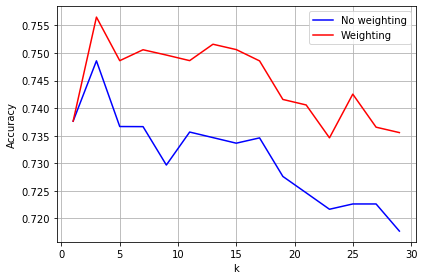

Grid search best params= {'n_neighbors': 3, 'weights': 'distance'} Accuracy= 0.7565148514851485


In [13]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [14]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[ 12  23   0   0   0]
 [  8 250  17   1   0]
 [  1  30  49   8   0]
 [  0   1  15   8   1]
 [  0   0   3   4   1]]
Accuracy: 0.7407407407407407, F1: 0.7253847720842422, Precision: 0.7218306182121971, Recall: 0.7218306182121971


As we can see it clearly recognizes the second level but not the others. Especially the level 1 and 4 are quite wrong.

## 2.2. Only categorical features

In [15]:
# only categorical
X_train = train_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(X_train)
X_test = test_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(X_test)

### 10 cross-validation

In [16]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.7029703  0.66336634 0.8019802  0.67326733 0.63366337 0.65346535
 0.73       0.71       0.72       0.75      ]


In [17]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7038712871287128
0.04773007318542114


### Find best parameters

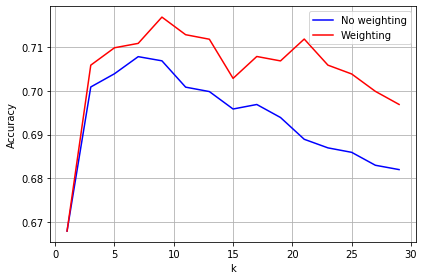

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7168019801980199


In [18]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [19]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[  7  28   0   0   0]
 [  9 249  18   0   0]
 [  0  41  45   2   0]
 [  0   8  11   3   3]
 [  0   3   2   3   0]]
Accuracy: 0.7037037037037037, F1: 0.6704461978450067, Precision: 0.6612969934069808, Recall: 0.6612969934069808


As the previous one it clearly recognizes the second level. However it totally misleads the 4th level and the 1st one.

## 2.3. Categorical and numerical features

In [20]:
X_train = train_data.copy()
transform_categorical_to_numerical(X_train)
X_test = test_data.copy()
transform_categorical_to_numerical(X_test)

### 10 cross-validation

In [21]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.72277228 0.67326733 0.81188119 0.67326733 0.67326733 0.66336634
 0.73       0.75       0.71       0.75      ]


In [22]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7157821782178218
0.044756159490860425


### Find best parameters

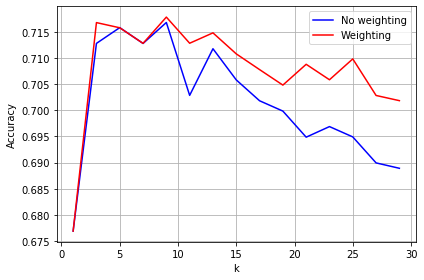

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7177920792079208


In [23]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [24]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[  7  28   0   0   0]
 [  9 247  20   0   0]
 [  0  39  46   3   0]
 [  0   8  11   3   3]
 [  0   3   3   2   0]]
Accuracy: 0.7013888888888888, F1: 0.6694575710921019, Precision: 0.6598321759259259, Recall: 0.6598321759259259


It is pretty similar to the last one.

## 2.4. Only numerical features from PCA

In [25]:
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()

### 10 cross-validation

In [26]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.77227723 0.73267327 0.74257426 0.78217822 0.71287129 0.76237624
 0.81       0.75       0.76       0.75      ]


In [27]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7574950495049505
0.025606688191740182


### Find best parameters

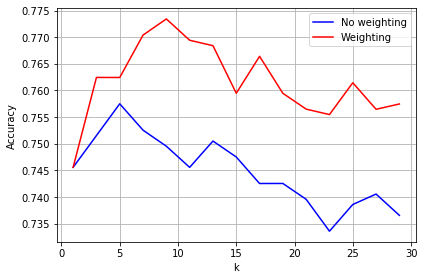

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7734257425742574


In [28]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [29]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[  9  26   0   0   0]
 [  7 255  14   0   0]
 [  0  26  53   8   1]
 [  0   0  10  15   0]
 [  0   0   3   3   2]]
Accuracy: 0.7731481481481481, F1: 0.7567883039118704, Precision: 0.7569322328441153, Recall: 0.7569322328441153


As we can see is better than the prior ones, but continue having the same errors.

## 2.5. Numerical features from PCA and categorical

In [30]:
cat_train = train_data.select_dtypes(include=['object','bool'])
cat_test = test_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(cat_train)
transform_categorical_to_numerical(cat_test)
cat_train['Id'] = id_train_data
cat_test['Id'] = id_test_data
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()
X_train['Id'] = id_train_pca_data
X_test['Id'] = id_test_pca_data
X_train = pd.merge(X_train, cat_train, on='Id')
X_test = pd.merge(X_test, cat_test, on='Id')
X_train.drop(columns=['Id'],inplace=True)
X_test.drop(columns=['Id'],inplace=True)

### 10 cross-validation

In [31]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.73267327 0.66336634 0.82178218 0.66336634 0.68316832 0.66336634
 0.73       0.76       0.73       0.74      ]


In [32]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7187722772277227
0.048666044465653306


### Find best parameters

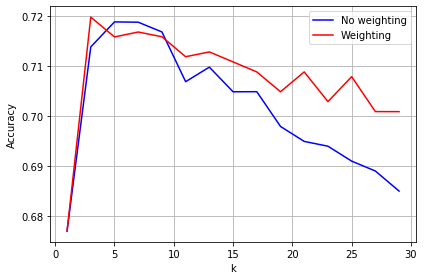

Grid search best params= {'n_neighbors': 3, 'weights': 'distance'} Accuracy= 0.7197326732673267


In [33]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [34]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[ 12  23   0   0   0]
 [ 16 232  26   2   0]
 [  1  33  47   6   1]
 [  0   5  12   4   4]
 [  0   1   1   3   3]]
Accuracy: 0.6898148148148148, F1: 0.6790252641101476, Precision: 0.6713851085891602, Recall: 0.6713851085891602


It is very similar to the previous ones.

# 3. Some modifications

In this section we are going to test some variations of the model which obtained the best accuracy in the last part: only with numerical features from PCA.

## 3.1. Balanced dataset

The feature to predict is very unbalanced, so we are gonna try to balance it in the training dataset and see if the accuracy increases.

In [35]:
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()

In [36]:
aux = train_pca_data.copy()
aux['SalePrice'] = y_train

X1 = aux[aux['SalePrice'] == 'Level1']
X2 = aux[aux['SalePrice'] == 'Level2']
X3 = aux[aux['SalePrice'] == 'Level3']
X4 = aux[aux['SalePrice'] == 'Level4']
X5 = aux[aux['SalePrice'] == 'Level5']

train_pca_data_balanced = pd.DataFrame()

for i in range(3):
    train_pca_data_balanced = train_pca_data_balanced.append(X1, ignore_index = True)
train_pca_data_balanced = train_pca_data_balanced.append(X2.sample(frac=1/3), ignore_index = True)
train_pca_data_balanced = train_pca_data_balanced.append(X3, ignore_index = True)
for i in range(4):
    train_pca_data_balanced = train_pca_data_balanced.append(X4, ignore_index = True)
for i in range(12):
    train_pca_data_balanced = train_pca_data_balanced.append(X5, ignore_index = True)

train_pca_data_balanced['SalePrice'].value_counts()

Level1    237
Level4    236
Level3    223
Level2    209
Level5    204
Name: SalePrice, dtype: int64

In [37]:
y_train_balanced = train_pca_data_balanced['SalePrice']
train_pca_data_balanced.drop(columns=['SalePrice'],inplace=True)

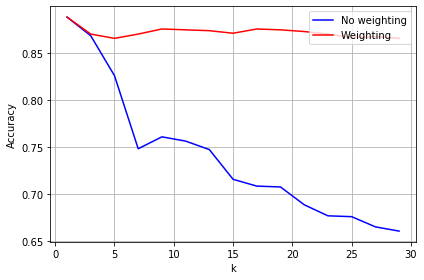

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7734257425742574


In [38]:
parval = find_best_params(train_pca_data_balanced,y_train_balanced)

In [39]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],train_pca_data_balanced,y_train_balanced,X_test,y_test)

[[ 31   4   0   0   0]
 [ 58 182  33   3   0]
 [  0   6  66  15   1]
 [  0   0   3  19   3]
 [  0   0   1   3   4]]
Accuracy: 0.6990740740740741, F1: 0.7212935305758168, Precision: 0.8011096313669402, Recall: 0.8011096313669402


We can see that the overall accuracy decreases but the different levels are more accurated than in the previous tests (the precision and recall are higher).

## 3.2. Change scorer function

Let's recall the results with the best model: only numerical from PCA

In [62]:
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()
pred = accuracy_with_test_data(9,'distance',X_train,y_train,X_test,y_test)
print('\n')
print(sklearn.metrics.classification_report(y_test, pred))

[[  9  26   0   0   0]
 [  7 255  14   0   0]
 [  0  26  53   8   1]
 [  0   0  10  15   0]
 [  0   0   3   3   2]]
Accuracy: 0.7731481481481481, F1: 0.7567883039118704, Precision: 0.7569322328441153, Recall: 0.7569322328441153


              precision    recall  f1-score   support

      Level1       0.56      0.26      0.35        35
      Level2       0.83      0.92      0.87       276
      Level3       0.66      0.60      0.63        88
      Level4       0.58      0.60      0.59        25
      Level5       0.67      0.25      0.36         8

    accuracy                           0.77       432
   macro avg       0.66      0.53      0.56       432
weighted avg       0.76      0.77      0.76       432



Imagine we want to increase the precision in the level 4 for some special reason as a company requirement. Let's change the optimizer to find the best parameters in this case.

In [71]:
scorer = sklearn.metrics.make_scorer(score_func=sklearn.metrics.precision_score, pos_label=4, greater_is_better=True,average='macro')
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring=scorer)
clf.fit(X_train, y_train)
print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)
pred = accuracy_with_test_data(clf.best_params_['n_neighbors'],clf.best_params_['weights'],X_train,y_train,X_test,y_test)
print('\n')
print(sklearn.metrics.classification_report(y_test, pred))

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.6684223872244099
[[  9  26   0   0   0]
 [  7 255  14   0   0]
 [  0  26  53   8   1]
 [  0   0  10  15   0]
 [  0   0   3   3   2]]
Accuracy: 0.7731481481481481, F1: 0.7567883039118704, Precision: 0.7569322328441153, Recall: 0.7569322328441153


              precision    recall  f1-score   support

      Level1       0.56      0.26      0.35        35
      Level2       0.83      0.92      0.87       276
      Level3       0.66      0.60      0.63        88
      Level4       0.58      0.60      0.59        25
      Level5       0.67      0.25      0.36         8

    accuracy                           0.77       432
   macro avg       0.66      0.53      0.56       432
weighted avg       0.76      0.77      0.76       432



We can see the grid search obtains the same parameters we had before.

## 3.3. Change distance metric

Let's do a grid search and a chart to find what is the best distance metric. We are doing this test with the numerical features obtained from PCA.

In [72]:
X_train = train_pca_data.copy()
X_test = test_pca_data.copy()

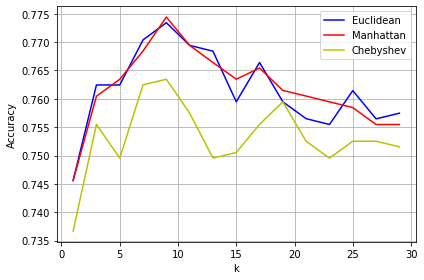

In [92]:
# Chart
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance',metric='euclidean'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='Euclidean')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance',metric='manhattan'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Manhattan')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance',metric='chebyshev'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'y',label='Chebyshev')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

In [95]:
#Grid search
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform'), 'metric': ('euclidean','manhattan','chebyshev')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)
clf.fit(X_train, y_train)
print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)

Grid search best params= {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7744158415841584


do test Mcnemar to check if they are different !!!!!!!!!!!!!!!!!!!!!!!!!!

### [Optional] Let's see how ammount of training data influences accuracy 

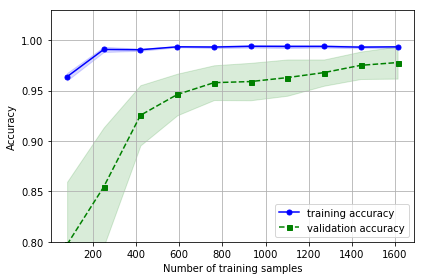

In [13]:
sklearn.metrics import make_scorerimport matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=nb.KNeighborsClassifier(n_neighbors=3),
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
3
plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()